### EarthQuake Mapping Using Sentinel 1 SLC

This demo uses Sentinel-1 SLC data, where pixels contain amplitude and phase. We take two SLCs (pre and post) around the Morocco earthquake: a reference image (often called “master”) and a secondary image (“slave”).

The processing pipeline includes:

TOPSAR-Split: Cuts each SLC down to the pieces that actually overlap, shrinking data and keeping only comparable bursts.

Apply Orbit-File: Attach precise satellite orbits to scenes.

Back-Geocoding (co-registration): Align the slave image onto the master image’s grid using the geometry and a DEM. For this to work the master and slave data must have the same swath.

Enhanced Spectral Diversity: Fine-tunes alignment between bursts using their overlap.

Interferogram: Combine the aligned complex images to get wrapped phase (the rainbow fringes).

TOPSAR-Deburst: Stitch bursts so the interferogram is continuous across the scene.

Multilook: Reduces speckle

Goldstein Phase Filtering: Denoise the interferometric phase

For this beginner demo, we stop at the wrapped interferogram (pretty rainbows). After this, you can continue to unwrap and convert to LOS displacement if you need numbers.




In [1]:

from pysarflow import read_slc_product, burst_for_geometry, topsar_split, apply_orbit, back_geocoding,  \
save_product, interferogram, topsar_deburst, plot, multilooking, goldstein_phase_filtering


Error while parsing JAI registry file "file:/Applications/esa-snap/snap/modules/org.esa.snap.snap-core/org-geotools/gt-coverage.jar!/META-INF/registryFile.jai" :
Error in registry file at line number #31
A descriptor is already registered against the name "org.geotools.ColorReduction" under registry mode "rendered"
Error in registry file at line number #32
A descriptor is already registered against the name "org.geotools.ColorInversion" under registry mode "rendered"
Error while parsing JAI registry file "file:/Applications/esa-snap/snap/modules/org.esa.snap.snap-core/org-jaitools/jt-zonalstats.jar!/META-INF/registryFile.jai" :
Error in registry file at line number #4
A descriptor is already registered against the name "ZonalStats" under registry mode "rendered"
Error while parsing JAI registry file "file:/Applications/esa-snap/snap/modules/org.esa.snap.snap-gpf/org-jaitools/jt-vectorize.jar!/META-INF/registryFile.jai" :
Error in registry file at line number #4
A descriptor is already 

In [2]:
from pathlib import Path 

# Load the manifest alone or the whole SAFE folder 
 
master_safe_dir = Path("../../S1A_IW_SLC_03.SAFE") 
slave_safe_dir = Path("../../S1A_IW_SLC_15.SAFE")


In [3]:
#Load the slc product  

master = read_slc_product("../../S1A_IW_SLC_03.SAFE") ## before the earthquake
slave =  read_slc_product("../../S1A_IW_SLC_15.SAFE")# after the earthquake

INFO: eu.esa.sar.commons.io.ImageIOFile: Using FileCacheImageInputStream


In [6]:

# Define AOI,  can be Shapely Point/Polygon, or WKT string, or bbox tuple (minlon,minlat,maxlon,maxlat)
wkt =  "POLYGON((-11.30 32.60, -6.40 32.60, -6.40 29.20, -11.30 29.20, -11.30 32.60))" #WKT string 


# get information about swath, bandname, bursts, first and last burst of the AOI
# the master and slave must have the same swath for a sensible coregistration to happen.
a = burst_for_geometry(master, master_safe_dir, wkt, subswath=None) # master
b = burst_for_geometry(slave, slave_safe_dir, wkt, subswath=None) # slave

print(a) # swath IW1
print(b) # swath IW1

#
topsar_a = topsar_split(master, a)
topsar_b = topsar_split(slave, a)

#apply orbit file
orbit_a = apply_orbit(topsar_a) 
orbit_b = apply_orbit(topsar_b) 

{'swath': 'IW1', 'band_name': 'i_IW1_VH', 'linesPerBurst': 1498, 'numberOfBursts': 10, 'geom_type': 'Polygon', 'firstBurst': 4, 'lastBurst': 4}
{'swath': 'IW1', 'band_name': 'i_IW1_VH', 'linesPerBurst': 1498, 'numberOfBursts': 10, 'geom_type': 'Polygon', 'firstBurst': 4, 'lastBurst': 4}

100% done.
TOPSAR-Split applied: IW1 bursts 4–4 (VH)

100% done.
TOPSAR-Split applied: IW1 bursts 4–4 (VH)

100% done.
Apply-Orbit-File: Sentinel Precise (Auto Download)

100% done.
Apply-Orbit-File: Sentinel Precise (Auto Download)


In [6]:
# you can save the output from each process into a local folder
save_product(orbit_a, "orbit_master")
# or
save_product(orbit_b, "orbit_slave")

Saving product to _results/orbit_master (BEAM-DIMAP)...
Product saved successfully.
Saving product to _results/orbit_slave (BEAM-DIMAP)...
Product saved successfully.


'_results/orbit_slave'

In [7]:

# back geocoding
bgg = back_geocoding([orbit_a, orbit_b])

Running Back-Geocoding...

100% done.
Back geocoding applied!


In [9]:
save_product(bgg, "bg")


Saving product to _results/bg (BEAM-DIMAP)...


INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N31W010.SRTMGL1.hgt.zip


Product saved successfully.


'_results/bg'

In [10]:
# interferogram
inter = interferogram(bgg)

# save the output
save_product(inter, "interferogram")

Creating interferogram ...

100% done.
Interferogram created!
Saving product to _results/interferogram (BEAM-DIMAP)...
Product saved successfully.


'_results/interferogram'

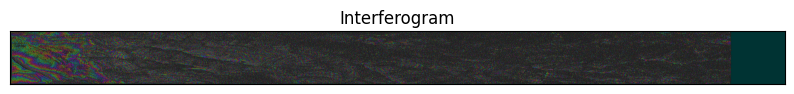

In [11]:

plot(
    "_results/interferogram.dim",
    i_band="i_ifg_IW1_VH_15Sep2023_03Sep2023",
    q_band="q_ifg_IW1_VH_15Sep2023_03Sep2023",
    coh_band="coh_IW1_VH_15Sep2023_03Sep2023",
    title = 'Interferogram',
    downsample=1,
    save_path="interferogram.png"
)


In [7]:
# deburst

polarization= 'VH'

deburst = topsar_deburst(inter, polarization)

Apply TOPSAR Deburst...

100% done.
TOPSAR Deburst applied!


In [24]:
#save product

save_product(deburst, "deburst")

Saving product to _results/deburst (BEAM-DIMAP)...
Product saved successfully.


'_results/deburst'

In [9]:
# Multilook

ml = multilooking(deburst, n_rg=3, n_az=1  )


100% done.


In [29]:
save_product(ml, "multilook")

Saving product to _results/multilook (BEAM-DIMAP)...
Product saved successfully.


'_results/multilook'

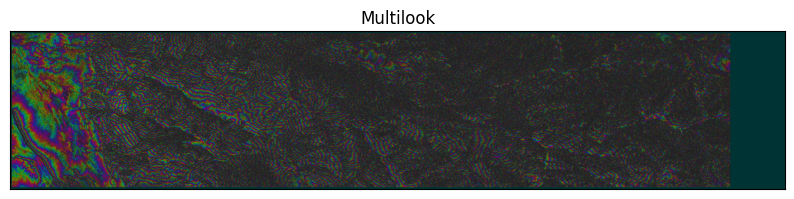

In [17]:
# plot the multilook 

plot(
    "_results/multilook.dim",
    i_band="i_ifg_IW1_VH_15Sep2023_03Sep2023",
    q_band="q_ifg_IW1_VH_15Sep2023_03Sep2023",
    coh_band="coh_IW1_VH_15Sep2023_03Sep2023",
    title = 'Multilook',
    downsample=1,
    save_path="phase_hsv.png"
)


In [13]:
# goldstein correction

fil = goldstein_phase_filtering(ml)

Apply Goldstein Phase Filtering...

100% done.
Goldstein Phase Filtering applied!


In [14]:
save_product(fil, 'goldstein_phase')

Saving product to _results/goldstein_phase (BEAM-DIMAP)...
Product saved successfully.


'_results/goldstein_phase'

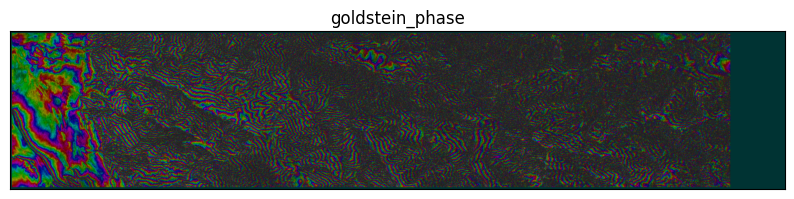

In [16]:
plot(
    "_results/goldstein_phase.dim",
    i_band="i_ifg_IW1_VH_15Sep2023_03Sep2023",
    q_band="q_ifg_IW1_VH_15Sep2023_03Sep2023",
    coh_band="coh_IW1_VH_15Sep2023_03Sep2023",
    title = 'goldstein_phase',
    downsample=1,
    save_path="goldstein_phase.png")